# Pulsar Prediction

## Introduction

### Background
Pulsars are a rare type of Neutron star which look like a “flickering star”. It flickers because it will produce two steady, narrow beams as it spins. They can produce radio emission detectable on Earth.

The extreme state matter of a pulsar can be used to find planets beyond our solar system, and measure the cosmic distance. Gravitational waves are outcomes from pulsars that could be evidence about energetic cosmic events like enormous black holes’ collision (Cofield, 2016).

A common method of finding a pulsar is radio telescopes. However, recently machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis.

### Question
Using the K-nearest neighbors algorithm, to what accuracy can we predict whether an observed star is a pulsar?

### Dataset
We are working with a Kaggle dataset which describes attributes about stars, along with labels of being pulsar stars or not. Since the testing dataset is not labelled, we are unable to use it for testing.


## Preliminary exploratory data analysis

### Importing libraries

In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(repr))
suppressMessages(library(tidymodels))
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”


### Reading data
Data was downloaded as CSV files. 
Kaggle provided training and testing data. It should be noted that Kaggle testing
data is unlabelled, so model evaluation must be done with some proportion of training
data.

In [2]:
pulsar_training = read_csv("https://raw.githubusercontent.com/FrankWhoee/pulsar/master/pulsar_data_train.csv",col_types = cols())

print(paste("pulsar_training has", nrow(pulsar_training), "observations,"))
print(paste(ncol(pulsar_training), "variables, and"))
print(paste(sum(rowSums(is.na(pulsar_training)) > 0), "NA observations."))
print("Column names before shortening are: ")
for(n in names(pulsar_training)){
    print(n)
}

[1] "pulsar_training has 12528 observations,"
[1] "9 variables, and"
[1] "3255 NA observations."
[1] "Column names before shortening are: "
[1] "Mean of the integrated profile"
[1] "Standard deviation of the integrated profile"
[1] "Excess kurtosis of the integrated profile"
[1] "Skewness of the integrated profile"
[1] "Mean of the DM-SNR curve"
[1] "Standard deviation of the DM-SNR curve"
[1] "Excess kurtosis of the DM-SNR curve"
[1] "Skewness of the DM-SNR curve"
[1] "target_class"


### Shortening column names

In [3]:
pulsar_names = c()
for(n in names(pulsar_training)){
    acroynm = ''
    for(word in str_split(n, ' ')){
        acroynm = paste(acroynm,substr(word,1,1), sep = '', collapse='')
    }
    pulsar_names = c(pulsar_names,acroynm)
}
names(pulsar_training)<-pulsar_names
print("Column names after shortening are: ")
for(n in names(pulsar_training)){
    print(n)
}

[1] "Column names after shortening are: "
[1] "Motip"
[1] "Sdotip"
[1] "Ekotip"
[1] "Sotip"
[1] "MotDc"
[1] "SdotDc"
[1] "EkotDc"
[1] "SotDc"
[1] "t"


### Removing NA entries

In [4]:
pulsar_training = na.omit(pulsar_training)
print(paste("pulsar_training has", nrow(pulsar_training), "observations,"))
print(paste(ncol(pulsar_training), "variables, and"))
print(paste(sum(rowSums(is.na(pulsar_training)) > 0), "NA observations."))
pulsar_training

[1] "pulsar_training has 9273 observations,"
[1] "9 variables, and"
[1] "0 NA observations."


Motip,Sdotip,Ekotip,Sotip,MotDc,SdotDc,EkotDc,SotDc,t
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.449874,65.15930,0
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.414652,102.72297,0
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.508364,74.03132,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
116.0312,43.21385,0.66345569,0.4330880,0.7851171,11.62815,17.055215,312.20433,0
135.6641,49.93375,-0.08994031,-0.2267262,3.8595318,21.50150,7.398395,62.33402,0
120.7266,50.47226,0.34617808,0.1847972,0.7692308,11.79260,17.662222,329.54802,0


### Data summary and visualization

We will split the data into positive and negative cases for a more accurate depiction, since there are approximately 10 times more negative cases.


In [5]:
# Data split
pulsar_pos = pulsar_training %>%
filter(t == 1)

pulsar_neg = pulsar_training %>%
filter(t == 0)

In [6]:
# Create plots
pulsar_plot = gather(pulsar_training) %>%
filter(key != 't') %>%
ggplot(aes(value)) +
geom_histogram(bins=15, fill='darkblue')+
facet_wrap(~key, scales = 'free_x')

pulsar_pos_plot = gather(pulsar_pos) %>%
filter(key != 't') %>%
ggplot(aes(value)) +
geom_histogram(bins=15, fill='coral')+
facet_wrap(~key, scales = 'free_x')

pulsar_neg_plot = gather(pulsar_neg) %>%
filter(key != 't') %>%
ggplot(aes(value)) +
geom_histogram(bins=15, fill='dodgerblue')+
facet_wrap(~key, scales = 'free_x')

#### Overall plot

We can see that EkotDc, Motip, and Sdotip have roughly normal distributions, but the rest are all skewed to the right.

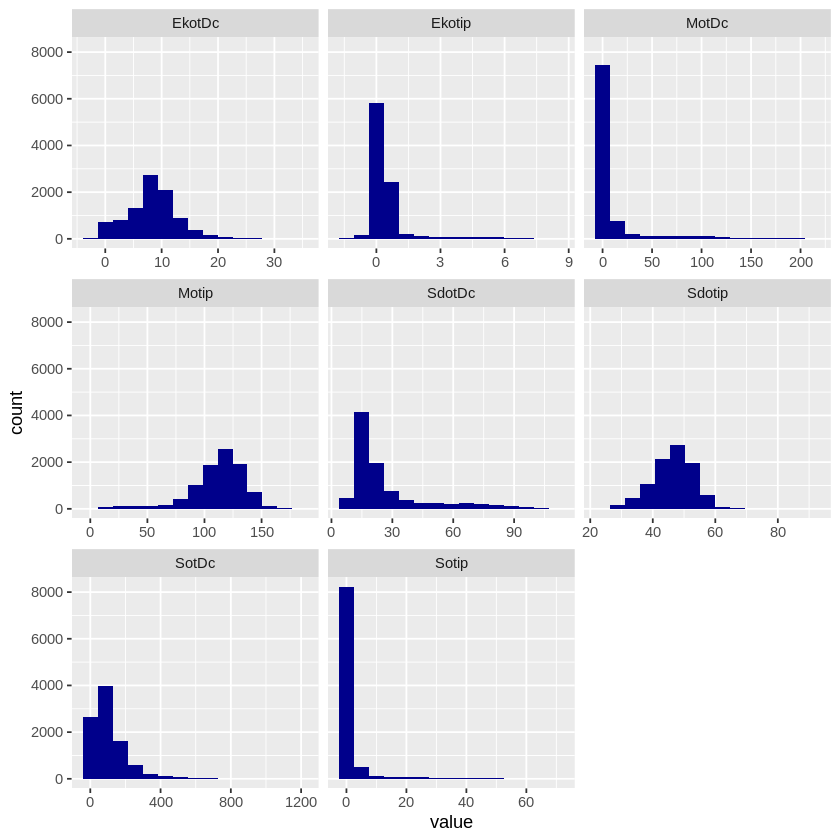

In [7]:
pulsar_plot

#### Negative plots

Due to the proportion of negative data, the overall plot and negative-only plot visualizations look identical.

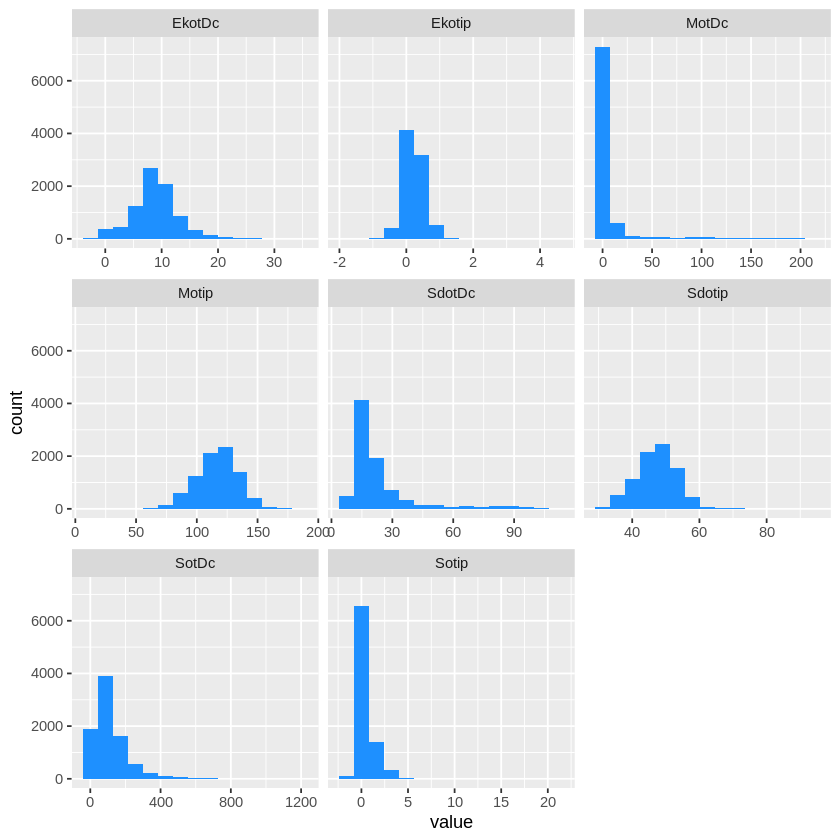

In [8]:
pulsar_neg_plot

#### Positive plots

The positive plots are dramatically different, however. Most notable are Ekotip, Motip, and SdotDc on account of their different skews and variances.

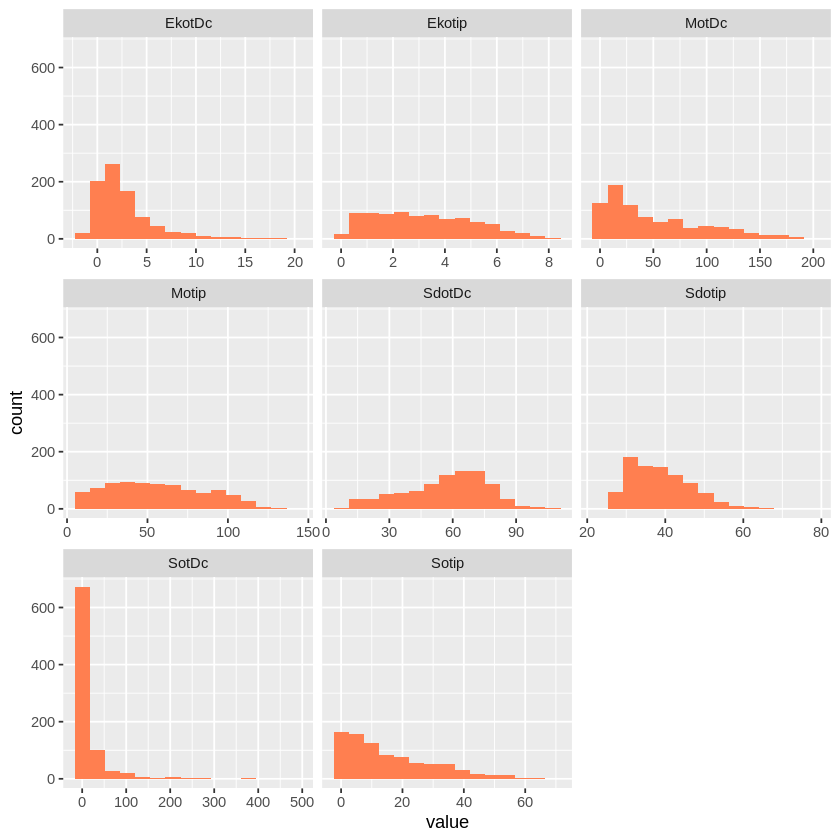

In [9]:
pulsar_pos_plot

#### Comparison of statistical attributes

In [10]:
# Part 1 - Getting means and stdev

posmeans = pulsar_pos %>% 
map_df(mean) %>%
select(-t) %>%
pivot_longer(cols=Motip:SotDc)
names(posmeans) <- c("name", "pos_mean")

posdev = pulsar_pos %>% 
map_df(sd) %>%
select(-t) %>%
pivot_longer(cols=Motip:SotDc) %>%
select(-name)
names(posdev) <- c("pos_stdev")

negmeans = pulsar_neg %>% 
map_df(mean) %>%
select(-t) %>%
pivot_longer(cols=Motip:SotDc)%>%
select(-name)
names(negmeans) <- c("neg_mean")

negdev = pulsar_neg %>% 
map_df(sd) %>%
select(-t) %>%
pivot_longer(cols=Motip:SotDc) %>%
select(-name)
names(negdev) <- c("neg_stdev")

summarized = cbind(posmeans,posdev, negmeans,negdev)
summarized %>% head(4)
summarized %>% tail(4)

,name,pos_mean,pos_stdev,neg_mean,neg_stdev
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Motip,56.490790,29.840725,116.6479988,17.4600853
2,Sdotip,38.653987,7.974646,47.3072449,6.1116413
3,Ekotip,3.146134,1.894812,0.2104498,0.3334176
4,Sotip,15.736526,14.396040,0.3833387,1.0040248


,name,pos_mean,pos_stdev,neg_mean,neg_stdev
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,MotDc,50.874638,45.938321,8.886566,24.51792
6,SdotDc,56.664961,19.746352,23.266417,16.70009
7,EkotDc,2.737318,3.085782,8.892105,4.28467
8,SotDc,17.793435,46.167913,114.662773,108.65428


## Method

### Feature Selection
To choose which features will be selected, we are using ANOVA (Mumtaz, 2020).

In [11]:
set.seed(2021)
aov.models = pulsar_training %>%
  map(~ summary(aov(pulsar_training$t ~ .x))[[1]][["F value"]][1])

as_tibble(aov.models) %>%
pivot_longer(cols=Motip:t, names_to="predictor") %>%
filter(predictor != 't') %>%
arrange(desc(value)) %>%
head(4)

summary(aov(t ~ Motip + Ekotip + Sotip + SdotDc, data=pulsar_training))

predictor,value
<chr>,<dbl>
Ekotip,15482.646
Sotip,9148.079
Motip,7794.219
SdotDc,2979.422


              Df Sum Sq Mean Sq F value Pr(>F)    
Motip          1  352.6   352.6 13154.0 <2e-16 ***
Ekotip         1  130.9   130.9  4884.1 <2e-16 ***
Sotip          1   23.7    23.7   885.2 <2e-16 ***
SdotDc         1   16.3    16.3   609.1 <2e-16 ***
Residuals   9268  248.5     0.0                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Data Prep

In [12]:
set.seed(2021)
split_data <- initial_split(pulsar_training, prop=0.75, strata=t)

training_data <- training(split_data)
testing_data  <- testing(split_data)

training_data$t <- as.factor(training_data$t)
testing_data$t <- as.factor(testing_data$t)

## Recipe Creation

In [13]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

rec <- recipe(t ~ Motip + Ekotip + Sotip + SdotDc, data = training_data)

## Perform 5-fold cross-validation

In [14]:
set.seed(2021)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
crossv = vfold_cv(training_data, v = 5, strata = t)

wf <- workflow() %>%
       add_recipe(rec) %>%
       add_model(knn_spec) %>%
       tune_grid(resamples = crossv, grid = 10) 
wf_metrics = collect_metrics(wf)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9653487,5,0.001645654,Model1
2,roc_auc,binary,0.9202354,5,0.008401960,Model1
3,accuracy,binary,0.9746945,5,0.002655095,Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.9536097,5,0.006264749,Model8
14,accuracy,binary,0.9784328,5,0.001746220,Model9
14,roc_auc,binary,0.9540666,5,0.006656410,Model9


[1] 0.9784328

[1] 14

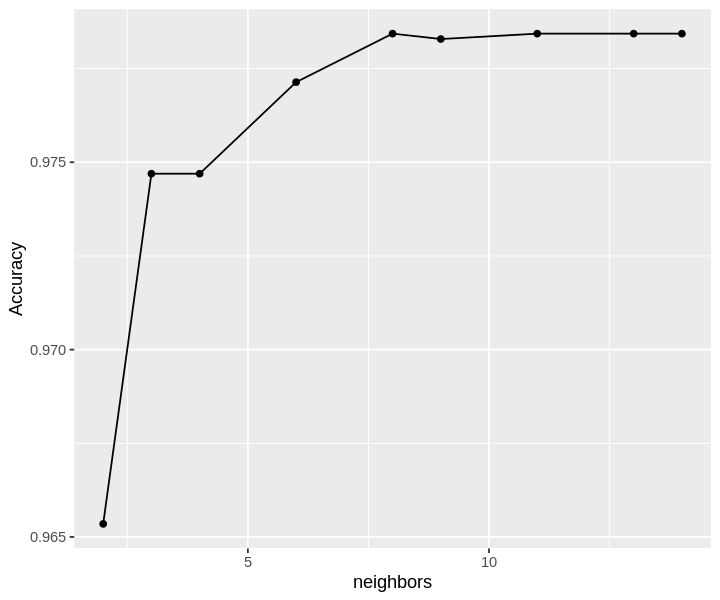

In [15]:
options(repr.plot.height = 5, repr.plot.width = 6)

wf_metrics
cross_val_plot <- wf_metrics %>% 
filter(.metric == "accuracy") %>%
ggplot(aes(x=neighbors,y=mean)) +
geom_point()+
geom_line()+
ylab("Accuracy")


cross_val_plot
wfm2 = wf_metrics %>% 
filter(.metric == "accuracy")
max(wfm2$mean)

chosen_k = wf_metrics %>% 
filter(.metric == "accuracy") %>%
arrange(mean) %>%
tail(1) %>%
select(neighbors) %>%
pull()

chosen_k

## Build Model

In [16]:
# your code here
final_spec = nearest_neighbor(weight_func = "rectangular", neighbors = chosen_k) %>%
       set_engine("kknn") %>%
       set_mode("classification")

final_fit = workflow() %>%
       add_recipe(rec) %>%
       add_model(final_spec) %>%
        fit(data = training_data)

In [19]:
set.seed(2021)

predictions = predict(final_fit, testing_data) %>%
bind_cols(testing_data)

final_metrics = metrics(predictions, .pred_class, t)
final_metrics
final_conf_mat = conf_mat(predictions, .pred_class,t)
final_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9788611
kap,binary,0.8720113


          Truth
Prediction    0    1
         0 2083   15
         1   34  186

### Data Analysis

First, we will create a recipe to preprocess our data.

As our dataset is very imbalanced, we want to rebalance the data in a way that can eliminate a falsely high accuracy rate for our model. We will do this by oversampling the positive cases.

We will use the K-nearest neighbors algorithm to classify our observations, and execute 5-fold cross-validation to find the optimal value of K to use.

Finally, we will fit the model and collect metrics on model performance, noting the accuracy we were able to obtain for our model.

One of the ways in which we plan on visualizing our findings is with a scatterplot, where each data point depicts one star. Whether each star is a pulsar star or not will be denoted by colour.


## Outcomes

We expect to discover which variables are most influential in the categorization of pulsar stars.

# Works Cited
Cofield, Calla. (2016, April 21). What Are Pulsars?. SPACE.COM. 
 https://www.space.com/32661-pulsars.html

Mumtaz, Asad. (2020, Jul 16). How to Find the Best Predictors for ML Algorithms. TOWARDSDATASCIENCE.COM. 
 https://towardsdatascience.com/how-to-find-the-best-predictors-for-ml-algorithms-4b28a71a8a80